In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from interpret.glassbox import ExplainableBoostingClassifier
import metrics


In [2]:
animal_data = pd.read_csv("animal_data_clean.csv")
animal_data.head()

,Group,A_C1W1T0,A_C2W1T0,L_C1W1T0,L_C2W1T0,A_C1W2T0,A_C2W2T0,L_C1W2T0,L_C2W2T0,A_C1W3T0,...,rC_C2W3T2,lC_C2W4T2,cC_C2W4T2,rC_C2W4T2,lC_C2W5T2,cC_C2W5T2,rC_C2W5T2,Level_70_70,Level_70_90,Level_90_90
0,0,0.000002,0.000003,1.352459,11.270492,0.000005,0.000006,2.090164,12.008197,0.000004,...,0.000258,0.000033,0.000092,0.000078,0.000058,0.000031,0.000016,True,False,False
1,0,0.000002,0.000005,1.311475,11.188525,0.000005,0.000008,2.008197,11.885246,0.000004,...,0.000228,0.000090,0.000122,0.000080,0.000059,0.000041,0.000010,False,True,False
2,0,0.000004,0.000004,1.311475,11.229508,0.000008,0.000008,2.049180,12.008197,0.000006,...,0.000209,0.000104,0.000096,0.000037,0.000078,0.000073,0.000030,False,False,True
3,0,0.000006,0.000006,1.352459,11.270492,0.000005,0.000006,2.131148,12.049180,0.000004,...,0.000091,0.000044,0.000081,0.000074,0.000026,0.000055,0.000030,True,False,False
4,0,0.000005,0.000010,1.311475,11.188525,0.000006,0.000008,2.049180,11.926230,0.000004,...,0.000140,0.000084,0.000098,0.000063,0.000033,0.000022,0.000017,False,True,False


In [3]:
Y = animal_data['Group']
X = animal_data.drop(['Group'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

zscore_scaler = MinMaxScaler()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train_normalized = X_train.copy()  
X_train_normalized[numeric_columns] = zscore_scaler.fit_transform(X_train[numeric_columns])

# Transform the testing data using the same scaler to avoid data leakage
X_test_normalized = X_test.copy()  
X_test_normalized[numeric_columns] = zscore_scaler.transform(X_test[numeric_columns])

In [4]:
## hyperparameter tuning
learning_rates = [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.5,1]
skf = StratifiedKFold(n_splits=5)
grid_result_list = []

In [12]:

for rate in learning_rates:
    grid_result = {}
    grid_result['learning_rate'] = rate
    
    for i,(train_index,test_index) in enumerate(skf.split(X_train_normalized,y_train)):
        train_features, train_label = X_train_normalized.iloc[train_index], y_train.iloc[train_index]
        test_features, test_label = X_train_normalized.iloc[test_index], y_train.iloc[test_index]

        ## define model 
        ebm_classifier = ExplainableBoostingClassifier(learning_rate=rate)  ## setting the random_state for reproducability
        ebm_classifier.fit(train_features,train_label)

        ypred = ebm_classifier.predict(test_features)
        dt_metrics = metrics.metrics(test_label,ypred)
        precisions,recalls,f1_scores,macro_f1,weighted_f1 = dt_metrics.f1_score()
        acc = dt_metrics.compute_accuracy()

        grid_result[f'accuracy_fold{i}'] = acc
        grid_result[f'f1_scores_fold{i}'] = f1_scores
        grid_result[f'macro_f1_fold{i}'] = macro_f1
        grid_result[f'weighted_f1_fold{i}'] = weighted_f1
        
    ##compute the average values
    grid_result['avg_acc'] = 0.2*sum([grid_result[f'accuracy_fold{i}'] for i in np.arange(5)])
    grid_result['avg_weighted_f1'] = 0.2*sum([grid_result[f'weighted_f1_fold{i}'] for i in np.arange(5)])
    grid_result['avg_macro_f1'] = 0.2*sum([grid_result[f'macro_f1_fold{i}'] for i in np.arange(5)])
    grid_result_list.append(grid_result)


        

c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:933: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the break statement below that disables multiclass interactions can be removed.
  warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:933: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the break statement below that disables multiclass interactions can be removed.
  warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:933: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the break statement below that disables multiclass interactions can be removed.
  warn(
c:\Users\medha\anaconda3\envs\pytorch\lib\site-packa

In [13]:
grid_df = pd.DataFrame(grid_result_list)
grid_df.to_csv('grid_df_ebm.csv', index=False)

In [14]:
grid_df

,learning_rate,accuracy_fold0,f1_scores_fold0,macro_f1_fold0,weighted_f1_fold0,accuracy_fold1,f1_scores_fold1,macro_f1_fold1,weighted_f1_fold1,accuracy_fold2,...,f1_scores_fold3,macro_f1_fold3,weighted_f1_fold3,accuracy_fold4,f1_scores_fold4,macro_f1_fold4,weighted_f1_fold4,avg_acc,avg_weighted_f1,avg_macro_f1
0,0.0001,0.800000,"[0.8275862068965518, 0, 0.8571428571428571]",0.561576,0.673892,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.827586,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.870345,0.786849,0.682239
1,0.0010,0.800000,"[0.8275862068965518, 0, 0.888888888888889]",0.572158,0.686590,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.793103,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.863448,0.780101,0.681936
2,0.0100,0.766667,"[0.8000000000000002, 0, 0.8461538461538461]",0.548718,0.630256,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.896552,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.931034,"[0.962962962962963, 0.8, 0.923076923076923]",0.895347,0.868808,0.884368,0.800971,0.772877
3,0.0200,0.800000,"[0.8387096774193549, 0, 0.8799999999999999]",0.572903,0.686108,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.793103,...,"[0.9285714285714286, 1.0, 0.9166666666666666]",0.948413,0.867406,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.877241,0.800440,0.717224
4,0.0500,0.866667,"[0.896551724137931, 0.4, 0.923076923076923]",0.739876,0.771070,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.827586,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.883678,0.809074,0.720484
5,0.1000,0.800000,"[0.8387096774193549, 0, 0.8799999999999999]",0.572903,0.686108,0.931034,"[0.9333333333333333, 0.6666666666666666, 0.960...",0.853333,0.870805,0.827586,...,"[0.896551724137931, 0.8, 0.9166666666666666]",0.871073,0.804776,0.931034,"[0.9655172413793104, 0.5, 0.9600000000000001]",0.808506,0.880595,0.877241,0.792909,0.737467
6,0.2000,0.866667,"[0.9032258064516129, 0, 0.9600000000000001]",0.621075,0.805505,0.931034,"[0.9333333333333333, 0.6666666666666666, 0.960...",0.853333,0.870805,0.827586,...,"[0.888888888888889, 0.8, 0.923076923076923]",0.870655,0.804951,0.862069,"[0.9333333333333333, 0, 0.8799999999999999]",0.604444,0.784368,0.876782,0.793876,0.731329
7,0.5000,0.800000,"[0.8484848484848485, 0, 0.8695652173913043]",0.572683,0.685815,0.896552,"[0.896551724137931, 0.8, 0.9166666666666666]",0.871073,0.804776,0.827586,...,"[0.8387096774193549, 0.5, 0.8695652173913043]",0.736092,0.693065,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.849655,0.753472,0.680378
8,1.0000,0.666667,"[0.7222222222222222, 0, 0.7000000000000001]",0.474074,0.476296,0.517241,"[0.5517241379310344, 0, 0.5185185185185186]",0.356748,0.277359,0.620690,...,"[0.6875000000000001, 0.5, 0.5454545454545454]",0.577652,0.390870,0.724138,"[0.8235294117647058, 0, 0.6666666666666666]",0.496732,0.558485,0.629885,0.425187,0.468949


In [6]:
grid_results_ebm = pd.read_csv('grid_df_ebm.csv')
grid_results_ebm.head()

,learning_rate,accuracy_fold0,f1_scores_fold0,macro_f1_fold0,weighted_f1_fold0,accuracy_fold1,f1_scores_fold1,macro_f1_fold1,weighted_f1_fold1,accuracy_fold2,...,f1_scores_fold3,macro_f1_fold3,weighted_f1_fold3,accuracy_fold4,f1_scores_fold4,macro_f1_fold4,weighted_f1_fold4,avg_acc,avg_weighted_f1,avg_macro_f1
0,0.0001,0.800000,"[0.8275862068965518, 0, 0.8571428571428571]",0.561576,0.673892,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.827586,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.870345,0.786849,0.682239
1,0.0010,0.800000,"[0.8275862068965518, 0, 0.888888888888889]",0.572158,0.686590,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.793103,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.863448,0.780101,0.681936
2,0.0100,0.766667,"[0.8000000000000002, 0, 0.8461538461538461]",0.548718,0.630256,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.896552,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.931034,"[0.962962962962963, 0.8, 0.923076923076923]",0.895347,0.868808,0.884368,0.800971,0.772877
3,0.0200,0.800000,"[0.8387096774193549, 0, 0.8799999999999999]",0.572903,0.686108,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.793103,...,"[0.9285714285714286, 1.0, 0.9166666666666666]",0.948413,0.867406,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.877241,0.800440,0.717224
4,0.0500,0.866667,"[0.896551724137931, 0.4, 0.923076923076923]",0.739876,0.771070,0.965517,"[0.967741935483871, 0.6666666666666666, 1.0]",0.878136,0.937338,0.827586,...,"[0.896551724137931, 0.5, 0.8799999999999999]",0.758851,0.752937,0.896552,"[0.9333333333333333, 0, 0.9600000000000001]",0.631111,0.847816,0.883678,0.809074,0.720484


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


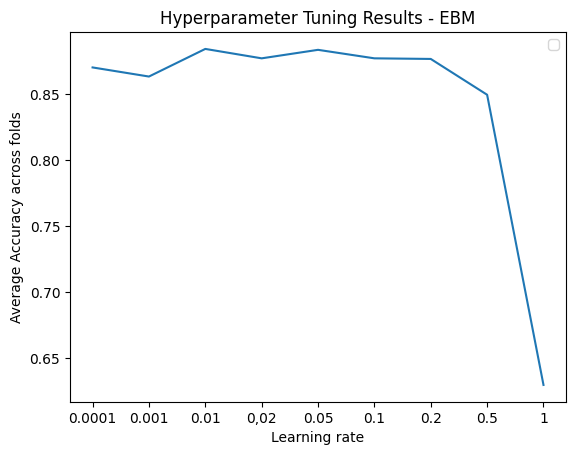

In [7]:
learning_rate = ['0.0001','0.001','0.01','0,02','0.05','0.1','0.2','0.5','1']  ## [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.5,1]
plt.plot(learning_rate,grid_results_ebm['avg_acc'])
plt.xlabel('Learning rate')
plt.ylabel('Average Accuracy across folds')
plt.legend()
plt.title('Hyperparameter Tuning Results - EBM')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


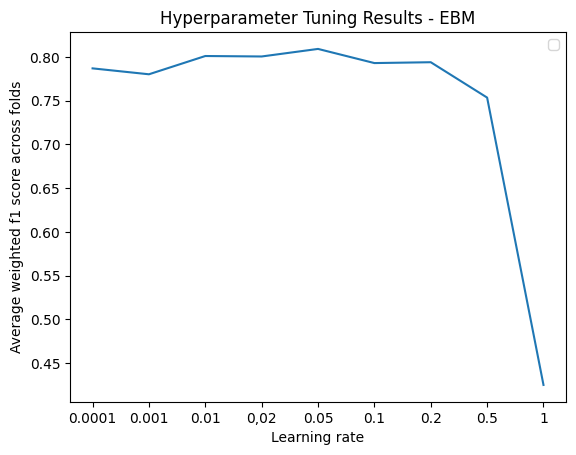

In [9]:
learning_rate = ['0.0001','0.001','0.01','0,02','0.05','0.1','0.2','0.5','1']  ## [0.0001,0.001,0.01,0.02,0.05,0.1,0.2,0.5,1]
plt.plot(learning_rate,grid_results_ebm['avg_weighted_f1'])
plt.xlabel('Learning rate')
plt.ylabel('Average weighted f1 score across folds')
plt.legend()
plt.title('Hyperparameter Tuning Results - EBM')
plt.show()

In [10]:
best_ebm_model = ExplainableBoostingClassifier(learning_rate=0.05)  ## setting the random_state for reproducability
best_ebm_model.fit(X_train_normalized,y_train)

y_pred = best_ebm_model.predict(X_test_normalized)
dt_metrics = metrics.metrics(y_test,y_pred)
precisions,recalls,f1_scores,macro_f1,weighted_f1 = dt_metrics.f1_score()
acc = dt_metrics.compute_accuracy()

c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:933: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions work except for global visualizations, so the break statement below that disables multiclass interactions can be removed.
  warn(


In [11]:
print('\n Accuracy:',acc)
print('\n f1 scores:',f1_scores)
print('\n weighted f1-score:',weighted_f1)
print('\n precisions:',precisions)
print('\n recalls:',recalls)
print('\n macro f1:',macro_f1)


 Accuracy: 0.9459459459459459

 f1 scores: [0.9444444444444444, 0.75, 1.0]

 weighted f1-score: 0.9001501501501502

 precisions: [0.9444444444444444, 0.75, 1.0]

 recalls: [0.9444444444444444, 0.75, 1.0]

 macro f1: 0.8981481481481483


## INTERPRETABILITY OF THE MODEL

In [17]:
from interpret import show
show(best_ebm_model.explain_global())

c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/3063891602256/ -->

In [18]:
show(best_ebm_model.explain_local(X_test_normalized[:5], y_test[:5]), 0)

c:\Users\medha\anaconda3\envs\pytorch\lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/3063908684896/ -->

## VARIABLE IMPORTANCE

In [21]:
best_ebm_model.term_importances()

array([0.22883864, 0.09844848, 0.06415592, 0.10578836, 0.07414392,
       0.11322056, 0.06083312, 0.04920219, 0.18010279, 0.14743678,
       0.06232211, 0.07718462, 0.05613323, 0.06900898, 0.0565643 ,
       0.08986199, 0.11668496, 0.04891832, 0.10609576, 0.11056768,
       0.04621703, 0.19766216, 0.08557308, 0.03440912, 0.10506232,
       0.06660608, 0.09556774, 0.10826872, 0.06121803, 0.0747872 ,
       0.04234603, 0.09418191, 0.14468951, 0.07247443, 0.08237704,
       0.10261072, 0.1395039 , 0.1062029 , 0.04628952, 0.03338967,
       0.09607305, 0.07460447, 0.07872474, 0.06047864, 0.07981851,
       0.07208843, 0.11355478, 0.06634453, 0.05532419, 0.06012798,
       0.20461502, 0.28415317, 0.05094914, 0.08343289, 0.10993624,
       0.13108764, 0.18545314, 0.07045149, 0.16112562, 0.11107445,
       0.10326478, 0.07727969, 0.05294293, 0.04519643, 0.08361929,
       0.09872696, 0.11510405, 0.12369321, 0.07179474, 0.07832853,
       0.14759941, 0.17580027, 0.14131706, 0.11043327, 0.11152

In [22]:
from sklearn.inspection import permutation_importance

In [23]:
## this follows the same method as model reliance calculation the distribution of the feature is messed up before prediction
result = permutation_importance(best_ebm_model, X_test_normalized, y_test, n_repeats=10,random_state=42)

In [24]:
important_variables_lr = {i:value for i,value in enumerate(result['importances_mean']) if value > 0}
important_var_indices = np.array([key for key,val in important_variables_lr.items()])
importance_scores = np.array([val for key,val in important_variables_lr.items()])

In [32]:
sorted_indices = np.argsort(importance_scores)[::-1]
sorted_scores = importance_scores[sorted_indices]
sorted_scores

array([0.04324324, 0.04054054, 0.04054054, 0.04054054, 0.03783784,
       0.03513514, 0.03513514, 0.03513514, 0.03243243, 0.03243243,
       0.02972973, 0.02702703, 0.02702703, 0.02702703, 0.02702703,
       0.02702703, 0.02702703, 0.02432432, 0.02432432, 0.02432432,
       0.02162162, 0.01891892, 0.01891892, 0.01891892, 0.01621622,
       0.01621622, 0.01621622, 0.01621622, 0.01621622, 0.01621622,
       0.01351351, 0.01351351, 0.01351351, 0.01081081, 0.01081081,
       0.01081081, 0.01081081, 0.01081081, 0.00810811, 0.00810811,
       0.00810811, 0.00810811, 0.00810811, 0.00810811, 0.00540541,
       0.00540541, 0.00540541, 0.00540541, 0.00540541, 0.00540541,
       0.00540541, 0.00540541, 0.00540541, 0.00540541, 0.00540541,
       0.00540541, 0.00540541, 0.00540541, 0.00540541, 0.0027027 ,
       0.0027027 , 0.0027027 , 0.0027027 , 0.0027027 , 0.0027027 ,
       0.0027027 , 0.0027027 ])

In [35]:
features = X_test_normalized.columns
sorted_feature_indices = important_var_indices[sorted_indices]
sorted_features = features[sorted_feature_indices]
sorted_features

Index(['A_C1W5T0', 'lC_C1W2T2', 'lC_C1W4T0', 'cC_C2W1T0', 'rC_C2W2T2',
       'cC_C2W2T2', 'lC_C2W4T2', 'cC_C2W4T0', 'lC_C1W5T0', 'rC_C2W1T0',
       'A_C1W5T2', 'cC_C1W3T2', 'A_C1W2T2', 'L_C2W2T2', 'Level_90_90',
       'L_C1W5T2', 'cC_C2W4T2', 'rC_C1W2T0', 'rC_C2W3T2', 'A_C2W5T2',
       'L_C1W2T2', 'rC_C1W2T2', 'A_C2W2T0', 'rC_C1W4T0', 'rC_C1W1T0',
       'rC_C2W2T0', 'A_C1W3T2', 'cC_C1W3T0', 'cC_C2W3T0', 'A_C1W1T2',
       'L_C1W5T0', 'lC_C2W2T2', 'L_C2W4T0', 'L_C2W4T2', 'lC_C1W4T2',
       'cC_C2W1T2', 'L_C2W2T0', 'rC_C1W1T2', 'A_C2W1T2', 'lC_C1W3T2',
       'A_C2W3T2', 'cC_C1W2T0', 'rC_C1W4T2', 'lC_C2W5T2', 'A_C2W5T0',
       'A_C2W4T0', 'A_C2W3T0', 'lC_C1W3T0', 'L_C2W5T2', 'L_C2W1T2',
       'Level_70_70', 'rC_C1W5T0', 'cC_C1W4T2', 'L_C1W4T2', 'L_C2W3T2',
       'rC_C2W4T0', 'cC_C1W5T0', 'rC_C1W3T2', 'A_C2W2T2', 'A_C2W4T2',
       'L_C1W3T2', 'cC_C1W5T2', 'cC_C1W1T0', 'rC_C2W3T0', 'lC_C2W3T0',
       'cC_C1W1T2', 'A_C1W2T0'],
      dtype='object')

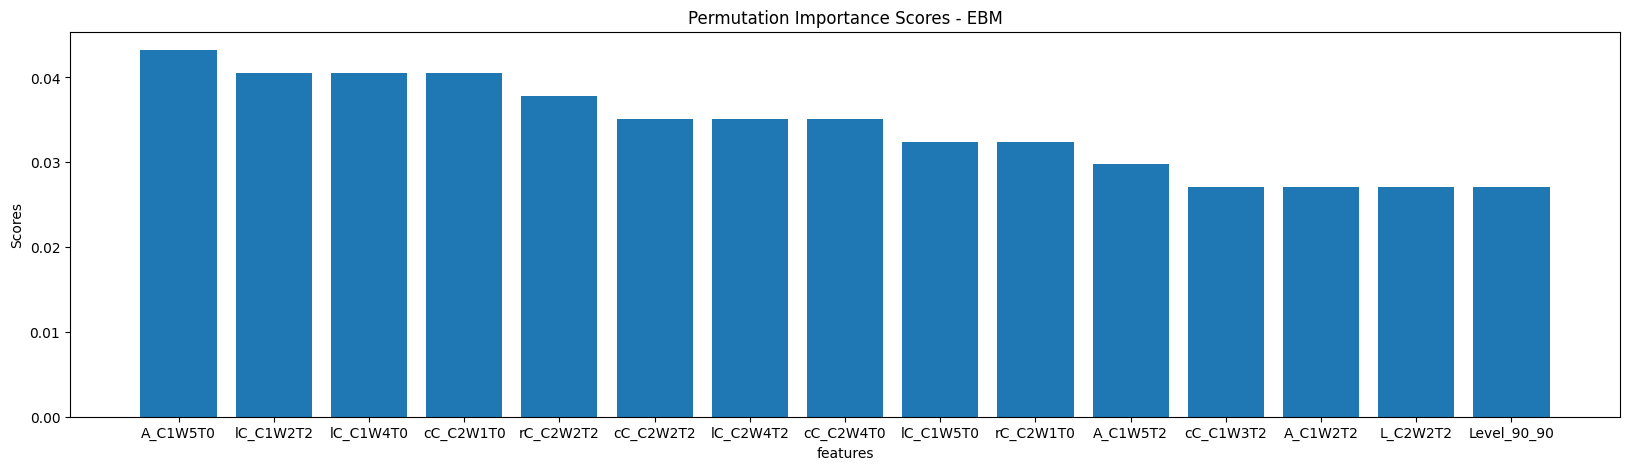

In [42]:
plt.figure(figsize=(20,5))
plt.bar(sorted_features[:15],sorted_scores[:15])
plt.xlabel('features')
plt.ylabel('Scores')
plt.title('Permutation Importance Scores - EBM')
plt.show()
